## MMM - v1

In this notebook, a core procedures to create a MMM - v1 by wrapping `orbit-ml` modules will be demonstrated. Sections include:

1. Libraries And Environment Check
2. Data Cleaning
3. Modeling
- Baseline Model
- Calibrate Priors Model [Optional]

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import karpiu
from karpiu.models import MMM

pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_rows', 50)

In [2]:
# print(orbit.__version__)
print(karpiu.__version__)

0.0.1


In [3]:
%load_ext autoreload
%autoreload 2

### Data

In [4]:
RAW_DATA_FILE = 'data.csv'
SCALABILITY_FILE = 'scalability_df.csv'
df = pd.read_csv(RAW_DATA_FILE, parse_dates=['date'])
scalability_df = pd.read_csv(SCALABILITY_FILE)
# df.head(5)
# print(df.dtypes)

In [5]:
adstock_df = pd.read_csv('./adstock.csv')
adstock_df = adstock_df.sort_values(by=['regressor'])
adstock_df = adstock_df.set_index('regressor')
# print(adstock_df.shape)
paid_channels = ['tv', 'radio', 'social', 'promo', 'search']

### Baseline Model

In [6]:
mmm = MMM(
    kpi_col='sales',
    date_col='date', 
    spend_cols=paid_channels,
    scalability_df=scalability_df,
    event_cols=[],
    seed=2022,
    adstock_df=adstock_df,
)

INFO:karpiu-mmm:Initialize model


You can obtain best smoothing params in the first run. In the future, you can directly use `set_hyper_params` to skip the tuning process.

In [7]:
mmm.optim_hyper_params(df)
mmm.best_params

INFO:karpiu-mmm:Optimize smoothing params. Only events and seasonality are involved.
INFO:karpiu-mmm:Pre-process data.


  0%|          | 0/45 [00:00<?, ?it/s]

INFO:karpiu-mmm:Best params damped_factor set as 0.94900
INFO:karpiu-mmm:Best params level_sm_input set as 0.02450
INFO:karpiu-mmm:Best params slope_sm_input set as 0.09430


{'damped_factor': 0.949,
 'level_sm_input': 0.024499999999999966,
 'slope_sm_input': 0.09430000000000005}

Users can access optimization result by `.tuning_df`.

In [8]:
# check optimization result
print(mmm.tuning_df.shape)
mmm.tuning_df.sample(5)

(45, 4)


,damped_factor,level_sm_input,slope_sm_input,metrics
27,0.94900,0.00380,0.09430,28199.62722
16,0.94900,0.02450,0.05940,22206.51429
32,0.99230,0.02450,0.02450,27094.73755
30,0.99230,0.02450,0.09430,22723.07748
20,0.94900,0.01933,0.02450,24173.67419


### Fitting

Fit the model with supplied dataframe.

In [9]:
mmm.fit(df)

INFO:karpiu-mmm:Fit final model.
INFO:karpiu-mmm:Pre-process data.
INFO:karpiu-mmm:Build a default regression scheme
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2000 and samples(per chain): 1000.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## Extracting Insights

### Attribution

In [10]:
from karpiu.explainer import Attributor

In [11]:
ATTR_START = '2019-03-01'
ATTR_END = '2019-03-31'
attributor = Attributor(model=mmm, start=ATTR_START, end=ATTR_END)
activities_attr_df, spend_attr_df, spend_df, cost_df = attributor.make_attribution()

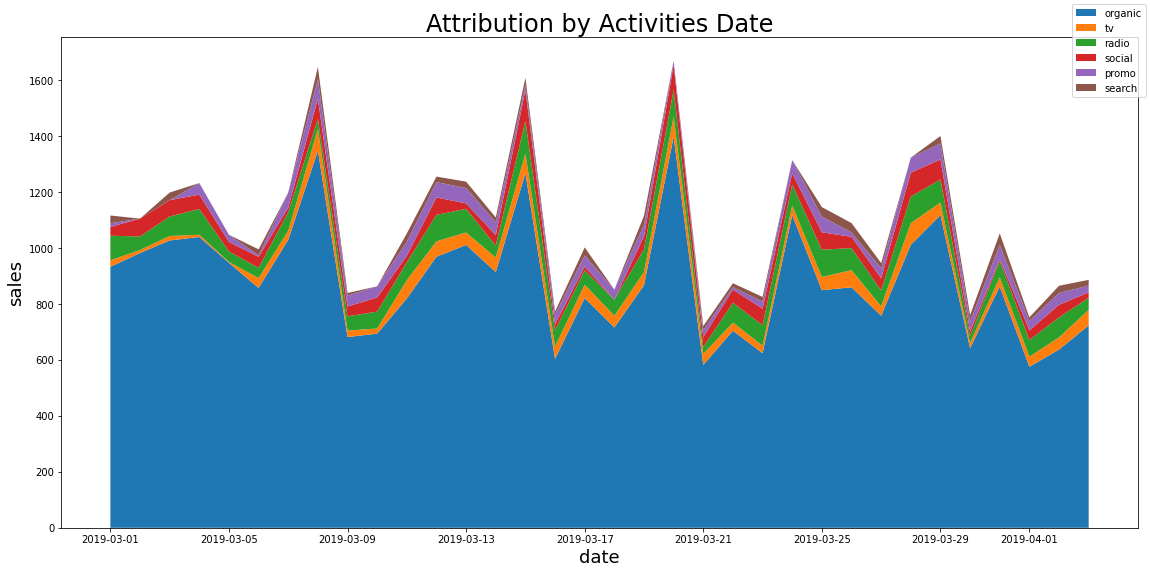

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.stackplot(
    activities_attr_df['date'].values, 
    activities_attr_df[['organic'] + paid_channels].values.transpose(), 
    labels=['organic'] + paid_channels
)
ax.set_title("Attribution by Activities Date", fontdict={'fontsize': 24})
ax.set_xlabel("date", fontdict={'fontsize': 18})
ax.set_ylabel("sales", fontdict={'fontsize': 18})
fig.legend()
fig.tight_layout();

### Model Regression Coefficents

In [13]:
mmm.get_regression_summary()

,regressor,sign,coef_p50,coef_p05,coef_p95,Pr(coef >= 0),Pr(coef < 0),loc_prior,scale_prior
0,promo,Positive,0.08906,0.02365,0.15786,1.00000,0.00000,0.00000,0.30000
1,radio,Positive,0.10514,0.05528,0.15499,1.00000,0.00000,0.00000,0.30000
2,search,Positive,0.03187,0.00591,0.06570,1.00000,0.00000,0.00000,0.30000
3,social,Positive,0.10869,0.03785,0.17797,1.00000,0.00000,0.00000,0.30000
4,tv,Positive,0.08965,0.02288,0.16201,1.00000,0.00000,0.00000,0.30000
